<a href="https://colab.research.google.com/github/Bader-Research/triangle-counting/blob/main/triangle_counting_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Generate Graph

In [ ]:
!pip install snap-stanford

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 11.6 MB 5.0 MB/s 


In [ ]:
sig_size = 5

class Edge:
  def __init__(self, src, dst):

    self.src = src                                      # Source of Edge (Node)
    self.dst = dst                                      # Destination of Edge (Node)
    self.type = 'Tree'                                  # Type of Edge

class Node:
  def __init__(self, label, degree):
    self.dist = -1                                      # distance from root
    self.visited = False                                # if the node has been visited (for BFS)
    self.label = label                                  # label for the node (int)
    self.degree = degree                                # degree (# of connections)
    self.weight = 'light'                               # describes the weight of the node (light or heavy) based on the degree - light by default

class Graph:
  def __init__(self, v):
    self.vertices = v                                   # number of total vertices
    self.adj = {}                                       # adjacency dictionary for the graph (key = each node & value = a list of it's neighbors)
    for i in range(v):
      self.adj[i] = []                                  # every value per key is an empty list (will contain the labels of neighbor nodes)
    self.edgeList = []                                  # list of total edges in graph
    self.root = 0                                       # root node's label is automatically 0
    self.sig_size = sig_size                            # size of signature agreement (to be set after threshold is calculated)
    self.node_list = {}                                 # dictionary of all nodes (key = label of node & value = address to the actual node in memory)
    lst = list(range(0, v))
    self.node_list = dict.fromkeys(lst)
    for i in range(v):
      self.node_list[i] = Node(i, 0)                    # make the value (actual node) for every key (node's label)

In [ ]:
# This is the code section to generate a directed RMAT graph and transcribe it to
# dictionary type undirected graph. It then runs BFS, classifies the edges, and
# returns the number of cross edges
import snap

SCALE = 20
q = pow(2,SCALE)                                      # number of vertices (n) = 2^scale
# (DAB) Why the constant 1.184... in the value computation of m?
# (DAB) And then m is reset later. Why?
m = round(1.18438720703125 * 16 * q)                  # number of edges (m) = 16 * n

Rnd = snap.TRnd()
RMAT = snap.GenRMat(q, m, .57, .19, .19, Rnd)           # Generate the Graph
                                                        # a = 0.57, b = 0.19, c = 0.19, d = 1 - (a+b+c)

m = 16 * q

g = Graph(q)                                            # initialize the graph

In [ ]:
tempEdgeList=[]
numOfEdgesNeeded = 0
edgeCount = 0
for EI in RMAT.Edges():                                # for every edge in the RMAT list of edges
  if edgeCount < m:
    n = EI.GetSrcNId()                                   # n = source node
    k = EI.GetDstNId()                                   # k = destination node
    numOfEdgesNeeded += 1
    if n not in g.adj[k]:
      tempEdgeList.append(str(n) + " " + str(k))
      #if(n < k):
      g.adj[n].append(k)
      #if(k < n):
      g.adj[k].append(n)
      edgeCount += 1
  else: break
edgeSet = set(tempEdgeList)

In [ ]:
print(edgeCount)
print(m)
print(numOfEdgesNeeded)

16777216
16777216
17338318


## Heavy & Light Nodes

In [ ]:
# Calculate the standard deviation and mean.
mean = 0                                            # For a Graph500 RMAT, the average vertex degree is 32. But, I am assuming that graphs can still have a mean slightly below or above.
SD = 0
summationMean = 0
summationSD = 0
for adjList in g.adj.values():                      #for each node
  summationMean += len(adjList)                       #add the length of its adjacency list to summationMean
mean = summationMean / g.vertices                   #divide summationMean by the total amount of vertices to find the average degree
for adjList in g.adj.values():                      #for each node
  summationSD += pow((len(adjList) - mean), 2)        #add (length of its adjacency list - mean)^2 to summationSD
SD = pow((summationSD / (g.vertices - 1)), 0.5)      #set SD to  √(summationSD divided by total number of vertices)
SD = round(SD)                                       #round SD to ensure it is an integer
mean = round(mean)                                   #round mean to ensure it is an integer
g.sig_size = pow(mean + (2 * SD), 2)                 #set sig size to (mean + 2*SD)^2
threshold = mean + (2 * SD);                         #set threshold to mean + 2*SD

In [ ]:
for node_label in g.adj:                             #for each node in the graph
  deg = len(g.adj[node_label])                        #set deg to the length of the node's adjacency list
  g.node_list[node_label].degree = deg                #update the node's degree in g.node_list (the dictionary with node objects)

In [ ]:
lst = list(range(0, g.vertices))
nodes = dict.fromkeys(lst)

heavyCount = 0;
for index in g.node_list.keys():                     #for each node object in g.node_list

  if (g.node_list[index].degree > threshold):        #if its degree is bigger than the treshold
    g.node_list[index].weight = 'heavy'                 #set its weight as heavy
    heavyCount += 1                                     #increment heavyCount

lightCount = g.vertices - heavyCount                 #Light node count is all vertices - the number of heavy vertices

g.sig_size = threshold                               #set the graph's signature size as the treshold

In [ ]:
for index in g.node_list:                            # for each node
  node = g.node_list[index]
  lst = list(range(0, g.sig_size))                    #create a list the size of the signature
  node.sig = dict.fromkeys(lst)                       #set the node's signature as the empty list in the form of a dictionary
  for i in node.sig.keys():                           #for each key in node's signature
    node.sig[i] = []                                    #set the key's value as a list so it can be appended later

## BFS

In [ ]:
def BFS(g):
    print(g.sig_size)                                   # double checks that the graph's signature size is correct
    numCross = 0                                        # Number of cross edges

    g.node_list[g.root].visited = True                  # root has been visited
    g.node_list[g.root].dist = 0                        # root's distance starts at 0
    queue = []                                          # initializes the queue
    queue.append(g.root)                                # root node is the first node in the queue

    while queue:                                        # Creating loop to visit each node
        s = queue.pop(0)                                # s is the value at the beginning of the queue

        for neighbor in g.adj[s]:                       # goes through each neighbor of s

          #signature as dict
          if(neighbor <= s):                                       #modified neighbors - only add neighbors with a smaller label
            key = hash(neighbor) % g.sig_size                      #hash the node and % by the size of signature agreement
            g.node_list[s].sig[key].append(neighbor)               #add the node to the list of nodes (the value) for the hashed key

          edge = Edge(s, neighbor)                                 # creates an edge with a given neighbor and s

          if g.node_list[neighbor].visited == False:               # as long as the neighbor has not been visited
            g.node_list[neighbor].dist = g.node_list[s].dist + 1 # neighbor's dist = s's dist + 1
            g.node_list[neighbor].visited = True                 # neighbor is marked as visited
            queue.append(neighbor)                               # neighbor is added to the queue

          else:
            if g.node_list[neighbor].dist == g.node_list[s].dist: # checks if the neighbor's and s's distance are equal (aka a cross edge)
              edge.type = "Cross"                                 # mark as cross edge
              numCross+=1                                         # numCross counter is incremented by 1

          if (str(neighbor) + " " + str(s)) not in edgeSet:
            g.edgeList.append(edge)                                 # edge is added to our edge list

    cross_edges = numCross/2                                        # cross_edges = final cross edge count
    total_edges = len(g.edgeList)                                 # total_edges = final edge count
    print("Number of Cross Edges:", cross_edges)                  # prints # of cross edges
    print("% of Cross Edges:", (cross_edges / total_edges)*100)   # prints % of cross edges over total edges

In [ ]:
BFS(g)

5
Number of Cross Edges: 6845.0
% of Cross Edges: 64.36900507805153


In [ ]:
light_edges = 0
heavy_edges = 0
light_and_heavy_edges = 0

print(len(g.edgeList))

for edge in g.edgeList:
  if edge.type == 'Cross':                                                            # if the edge is a cross edge
    n = edge.src                                                                      # n = source node
    k = edge.dst                                                                      # k = destination node
    if g.node_list[n].weight == 'light' and g.node_list[k].weight == 'light':         # if n and k are both light nodes --> then it's a light edge
      light_edges += 1
    elif g.node_list[n].weight == 'heavy' and g.node_list[k].weight == 'heavy':       # if n and k are both heavy nodes --> then it's a heavy edge
      heavy_edges += 1
    elif g.node_list[n].weight == 'heavy' and g.node_list[k].weight == 'light':       # if n is heavy and k is light --> then it's a light & heavy edge
      light_and_heavy_edges += 1
    elif g.node_list[n].weight == 'light' and g.node_list[k].weight == 'heavy':       # if n is light and k is heavy --> then it's a light & heavy edge
      light_and_heavy_edges += 1


16384


##Modified Neighborhood List

In [ ]:
for key in g.adj:
  for node_label in list(g.adj[key]):
    if(node_label < key):
      g.adj[key].remove(node_label)

In [ ]:
count_list = [0, 0, 0]
cost_list = [0, 0, 0]

for edge in g.edgeList:
  if(edge.type == 'Cross'):
    a = edge.src
    b = edge.dst
    length_a = len(g.adj[a])
    length_b = len(g.adj[b])
    m1 = length_a * SCALE                               #sending |A| * logn bits
    m2 = length_b * SCALE                               #sending |B| * logn bits
    m3 = q                                              #sending n bits (for the bit vector)

   min_list = [m1, m2, m3]

    min_value = min(min_list)
    cost_list[min_list.index(min_value)] += min_value
    for index, val in enumerate(min_list):              #if two methods have the same cost --> we are incrementing both counters
      if(val == min_value):
        count_list[index]+=1

print(count_list)
print(cost_list)

[1366, 7004, 578]
[468420, 1352880, 591872]


In [ ]:
print(q, m)
s = cost_list[0] + cost_list[1]
print(s)
print(s / (0.65 * m * q))

NameError: ignored

## Counting Triangles

In [ ]:
def triangle_count(graph):
  tc = 0                                                              # triangle count = 0
  for edge in graph.edgeList:

    if(edge.src.degree > edge.dst.degree):                            # if src_node degree > dst_node degree
      low = edge.dst                                                  # low_degree_node = dst
      high = edge.src                                                 # high_degree_node = src

    else:                                                             # if src_node degree < dst_node degree
      low = edge.src                                                  # low_degree_node = src
      high = edge.dst                                                 # high_degree_node = dst

    if(edge.label == 'Cross'):                                       # traverse through cross edges when counting triangles
      for key in high.sig:                                           # iterate through the high_degree_node signature to compare with low degree (sending high_degree_node's signature to low_degree_node)

        if(len(high.sig[key]) > 0 and (len(low.sig[key] > 0))):        # checks for a signature agreement for a particular index
            for node in low.sig[key]:                                # for each node in k.low.sig's list of values
                if node in high.sig[key]:                            # if that node appears in k.high.sig's list of values
                  tc += 1                                            # increment triangle count by 1

  print(tc)

## Counting Collisions

In [ ]:
def collision_count(graph):
  collision_node = 0
  collisions = 0
  for node in graph.node_list.values():                                     # for every node in the graph's node list (each value in the dictionary)
    flag = False
    for key in node.sig.keys():                                             # for every key in the node's signature
      num_collisions = len(node.sig[key])
      if(num_collisions > 1):                                                # if the array of values per key in the signature has more than 1 neighbor --> there is a collision
        collisions = collisions + num_collisions                             # increase collisions by the length of the bucket
        flag = True
    if (flag == True):
        collision_node += 1
  print("Number of Collisions: ", collisions)
  print("Number of nodes that has collisions", collision_node)

## Counting Number of Nodes With Degree Greater than Sqrt(n)

In [ ]:
def sqrtNVertices(graph):
  vertices = 0
  sqrtN = pow(n,0.5)
  for node in graph.adj:                                                    # for every node in the graph (each key value in the adjacency list)
    if(graph.node_list[node].degree >= sqrtN):                              # if the node's degree is greater than the square root of the number of vertices
      vertices += 1
  percent = vertices / graph.vertices
  print("Percentage of vertices > sqrt(n): ", percent * 100)

## Print Statistics

In [ ]:
print("Scale",SCALE, "Graph (", q, "Nodes and ", m, "Edges)\n" )
collision_count(g)
sqrtNVertices(g)

print("Heavy Nodes:", heavyCount, "(",(heavyCount/g.vertices)*100, "%) - Nodes with degree higher than", threshold)
print("Light Nodes:", lightCount, " - Nodes with degree lower than", threshold)
print("\n")

print("Threshold:", threshold)
print("Standard Deviation:", SD)
print("Mean:", mean)
print("\n")

total = light_edges + heavy_edges + light_and_heavy_edges
print("Total Cross Edges in the graph:", total)
print("Light Edges:", light_edges, "(", light_edges*100/total, "%) - Edges that have light nodes as both endpoints")
print("Heavy Edges:", heavy_edges, "(", heavy_edges*100/total, "%) - Edges that have heavy nodes as both endpoints" )
print("Light & Heavy Edges:", light_and_heavy_edges, "(", light_and_heavy_edges*100/total, "%)  - Edges that have 1 light and 1 heavy node as its endpoints")

Scale 10 Graph ( 1024 Nodes and  16384 Edges)

Number of Collisions:  0
Number of nodes that has collisions 0
Percentage of vertices > sqrt(n):  18.06640625
Heavy Nodes: 41 ( 4.00390625 %) - Nodes with degree higher than 102
Light Nodes: 983  - Nodes with degree lower than 102


Threshold: 102
Standard Deviation: 43
Mean: 16


Total Cross Edges in the graph: 8915
Light Edges: 3847 ( 43.151991026360065 %) - Edges that have light nodes as both endpoints
Heavy Edges: 578 ( 6.483454851374089 %) - Edges that have heavy nodes as both endpoints
Light & Heavy Edges: 4490 ( 50.364554122265844 %)  - Edges that have 1 light and 1 heavy node as its endpoints


##Statistics

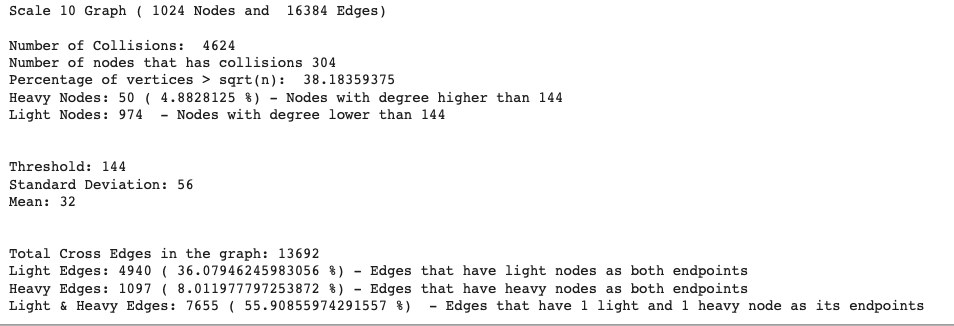

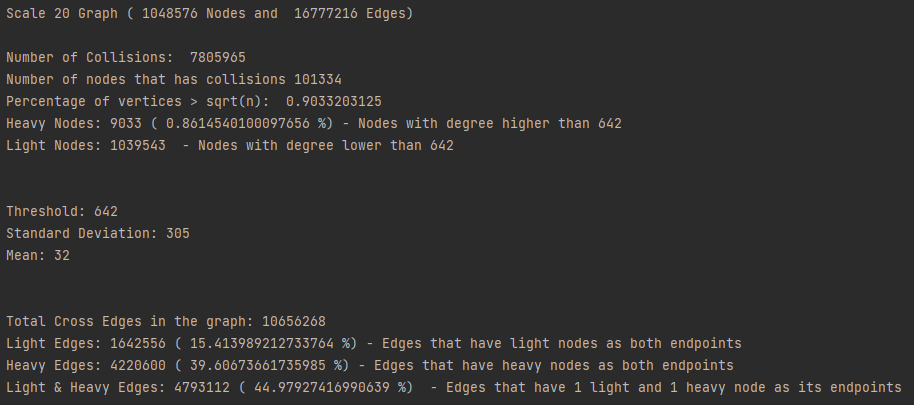